In [20]:
library(tidyverse)
library(tidymodels)
library(janitor)
library(leaps)
library(GGally)

# STAT 306 Group C3 Project

# The Data & Goal Analysis

The data being explored is the [Real Estate Valuation Data Set](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set) that explores real-estate prices in Sindian Dist., New Taipei City, Taiwan. This data consists of n=414 observations that contain various numerical and time-related features. This data was obtained through UC Irvine Machine Learning Repository.

The variables we have are: 
- X1 =  The transaction date in numerical units. For instance, 2013.250 equals March 2013, where the month is depicted as a fraction of the year (3/12 = 0.250) 
- X2 = The house age in years
- X3 = Distance to the nearest MRT station in metres (MRTs are metro transit systems) 
- X4 = Number of convenience stores in the living circle on foot by count (integer)
- X5 = Latitude in degree
- X6 = Longitude in degree

**The primary objective of this analysis is to determine how the real estate price is influenced by various factors such as house age, proximity to transportation (MRT), convenience store availability, and geographical location.**

# Reading In the Data

In [21]:
real_estate_data <- read_csv("./data/real_estate.csv")
real_estate_data <- clean_names(real_estate_data)
head(real_estate_data)

set.seed(123) # for reproducibility
df_split <- initial_split(real_estate_data, prop = 0.8, strata = y_house_price_of_unit_area)
train_df <- training(df_split)
test_df <- testing(df_split)

Rows: 414 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (8): No, X1 transaction date, X2 house age, X3 distance to the nearest M...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


no,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012.917,32.0,84.87882,10,24.98298,121.5402,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.5395,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.5439,47.3
4,2013.500,13.3,561.98450,5,24.98746,121.5439,54.8
5,2012.833,5.0,390.56840,5,24.97937,121.5425,43.1
6,2012.667,7.1,2175.03000,3,24.96305,121.5125,32.1


# Exploratory Data Analysis

To begin our EDA, we first determine the severity of our missing data

In [22]:
df_train <- train_df
na_count <- data.frame(sapply(df_train, function(y) sum(is.na(y))))
na_count

,sapply.df_train..function.y..sum.is.na.y...
,<int>
no,0
x1_transaction_date,0
x2_house_age,0
x3_distance_to_the_nearest_mrt_station,0
x4_number_of_convenience_stores,0
x5_latitude,0
x6_longitude,0
y_house_price_of_unit_area,0


As determined in the above code cell, there are no observations with missing data; we may proceed without any data imputation.



As per the objective of this project, we explore house age, distance to the nearest mrt station, number of convenience stores, and geographical location in relation to the response variable: the house price of unit area. The transaction date feature was dropped as it incorporates a time series component; this greatly increases the complexity of the task and demands the assertion of several strong assumptions for any model within the scope of STAT 306.

To create a feature for geographical location, we must discretize the longitude and latitude features together; this allows for a simpler analysis. We use k-means clustering to combine the two features into one.

In [23]:
# Create location-based features
kmeans_model <- kmeans(df_train[, c('x5_latitude', 'x6_longitude')], centers = 5)

predict_kmeans <- function(new_data, kmeans_model) {
  distances <- as.matrix(dist(rbind(kmeans_model$centers, new_data)))
  distances <- distances[1:nrow(kmeans_model$centers), (nrow(kmeans_model$centers) + 1):ncol(distances)]
  cluster_assignments <- apply(distances, 2, which.min)
  return(cluster_assignments)
}

df_train$neighborhood <- predict_kmeans(df_train[, c('x5_latitude', 'x6_longitude')], kmeans_model)

A simple next step would be to explore the basic summary statistics of our data.

In [24]:
df_summary <- df_train %>%
    select(
        x2_house_age,
        x3_distance_to_the_nearest_mrt_station,
        x4_number_of_convenience_stores,
        x5_latitude,
        x6_longitude,
        y_house_price_of_unit_area
    )

df_summary <- do.call(cbind, lapply(df_summary, summary)) %>% t() %>% round(3)
df_summary

write.csv(df_summary, "figures/table1.csv", row.names=TRUE)

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
x2_house_age,0.000,8.500,15.900,17.522,27.600,43.800
x3_distance_to_the_nearest_mrt_station,23.383,289.325,492.231,1087.988,1455.798,6488.021
x4_number_of_convenience_stores,0.000,1.000,4.000,4.009,6.000,10.000
x5_latitude,24.932,24.963,24.971,24.969,24.977,25.015
x6_longitude,121.474,121.528,121.538,121.533,121.543,121.566
y_house_price_of_unit_area,7.600,27.700,38.500,38.012,46.600,117.500


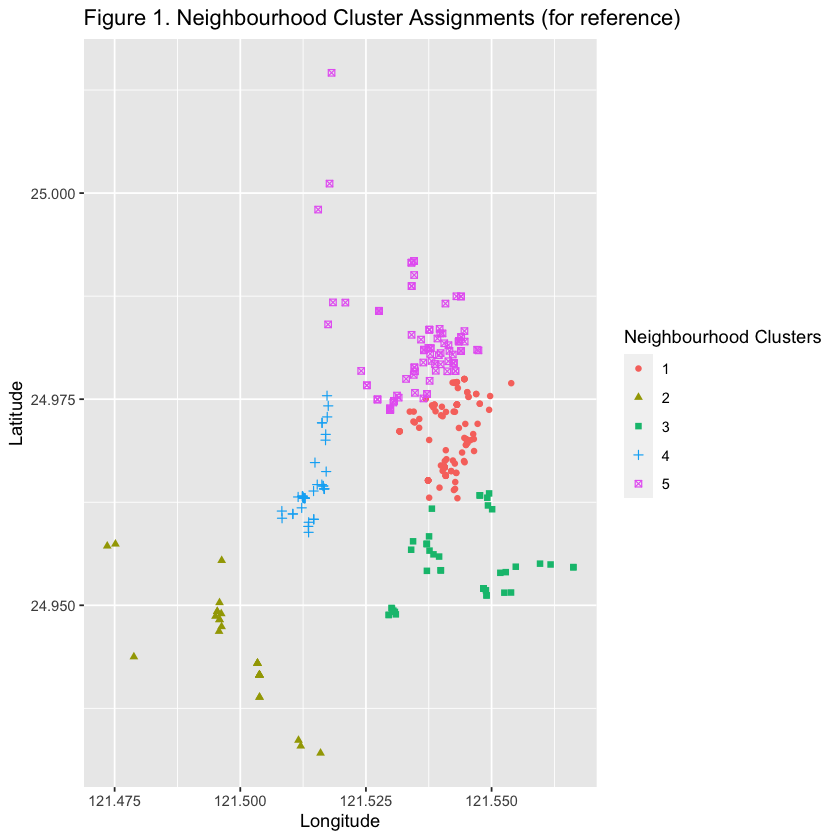

In [25]:
figure_1 <- df_train %>%
    ggplot(aes(x = x6_longitude, y = x5_latitude, colour = as.factor(neighborhood), shape = as.factor(neighborhood))) +
        geom_point() + 
        xlab("Longitude") + 
        ylab("Latitude") +
        labs(colour = 'Neighbourhood Clusters', shape = 'Neighbourhood Clusters') + 
        ggtitle("Figure 1. Neighbourhood Cluster Assignments (for reference)")

figure_1
ggsave("figures/fig_1.png", figure_1, width = 20, height = 10, units = "cm")

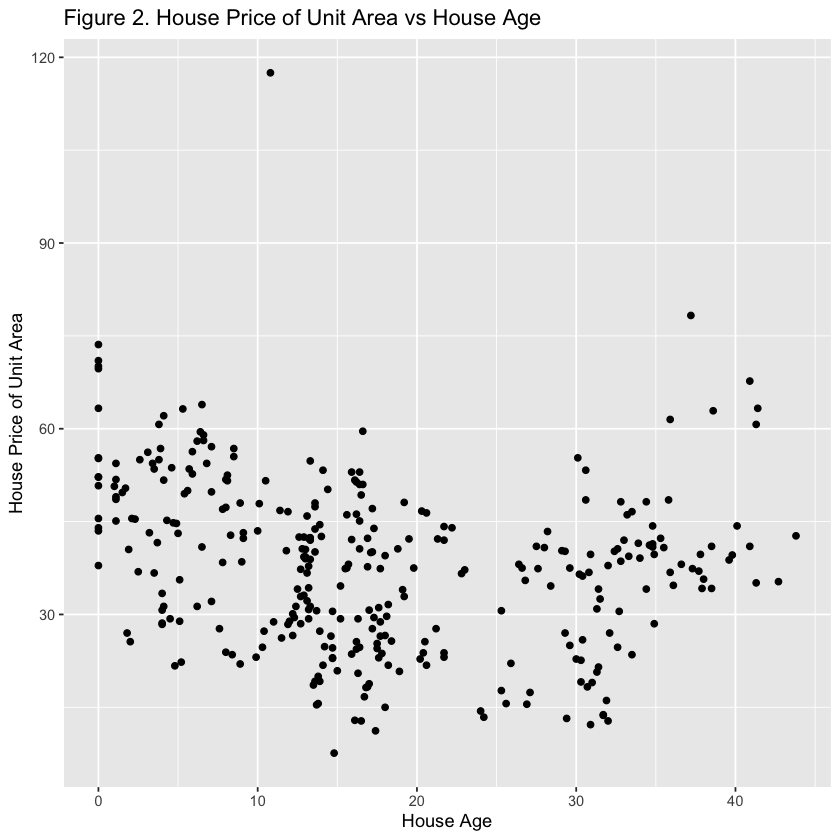

In [26]:
fig_2 <- df_train %>%
    ggplot(aes(x = x2_house_age, y = y_house_price_of_unit_area)) +
        geom_point() + 
        xlab("House Age") + 
        ylab("House Price of Unit Area") +
        ggtitle("Figure 2. House Price of Unit Area vs House Age")

fig_2 
ggsave("figures/fig_2.png", fig_2, width = 20, height = 10, units = "cm")

From the above graph, we can determine that there exists a some relationship between house age and price. It can be observed that prices lower as houses get older, however, at around 30 years, the price of these houses can remain high. This could potentially be explained by the types of houses that have lasted for over 30 years. For example, apartment buildings might have been demolished after 30 years to build new ones whereas single family homes may have been maintained for much longer. This could be supported by the existence of fewer observations for houses older than 30 years

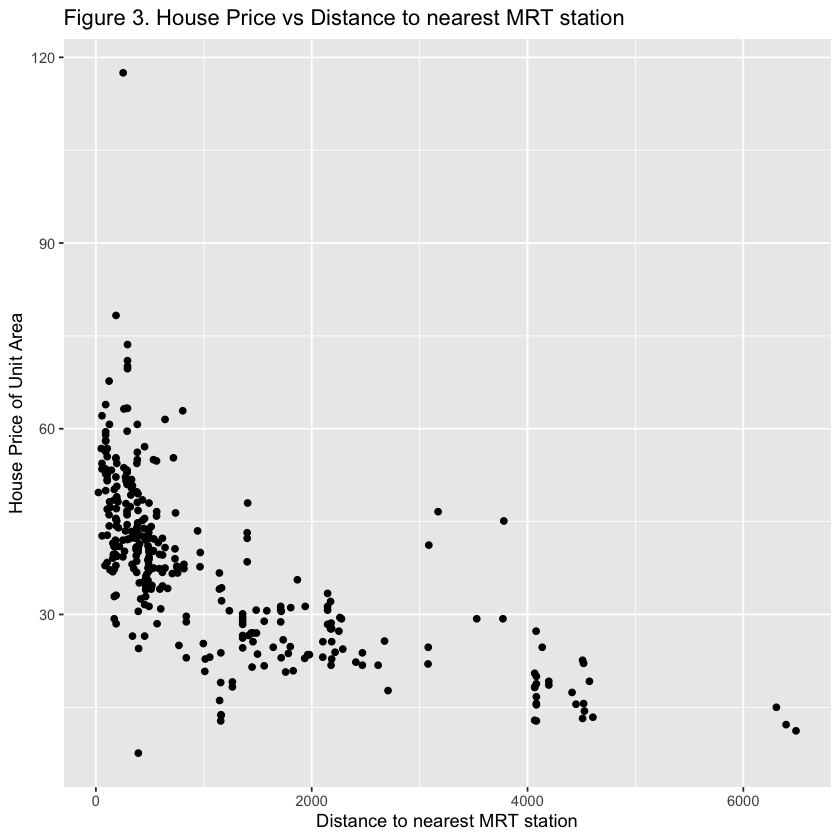

In [27]:
fig_3 <- df_train %>%
    ggplot(aes(x = x3_distance_to_the_nearest_mrt_station, y = y_house_price_of_unit_area)) +
        geom_point() + 
        xlab("Distance to nearest MRT station") + 
        ylab("House Price of Unit Area") +
        ggtitle("Figure 3. House Price vs Distance to nearest MRT station")

fig_3 
ggsave("figures/fig_3.png", fig_3, width = 20, height = 10, units = "cm")

From the above graph, it seems there is a strong correlation between a house's distance to the nearest MRT station and its price. Homes closer to MRT stations are likely ones within a densely populated area; this would likely bring up the price

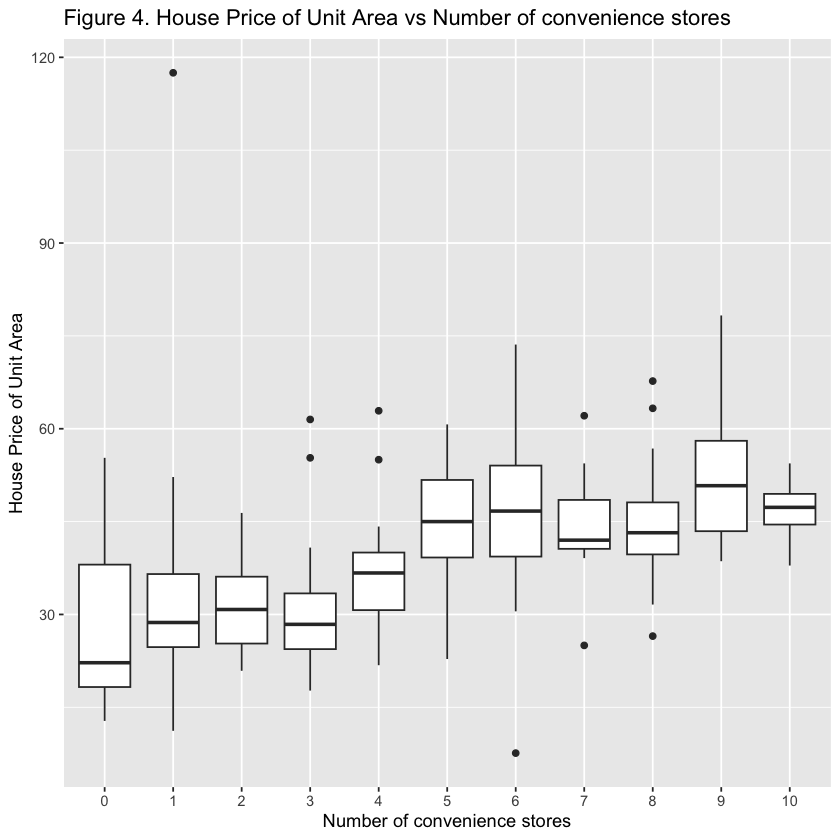

In [28]:
fig_4 <- df_train %>%
    ggplot(aes(x = as.factor(x4_number_of_convenience_stores), y = y_house_price_of_unit_area)) +
        geom_boxplot() + 
        xlab("Number of convenience stores") + 
        ylab("House Price of Unit Area") +
        ggtitle("Figure 4. House Price of Unit Area vs Number of convenience stores")

fig_4 
ggsave("figures/fig_4.png", fig_4, width = 20, height = 10, units = "cm")

Since the number of convenience store is represented as an integer, the most appropriate visualization would be through a box plot. This demonstrates that housing prices tend to increase as the number of convenience stores increase. This is likely a result of the appeal of many nearby convenience stores which can offer a variety of shopping and food options.

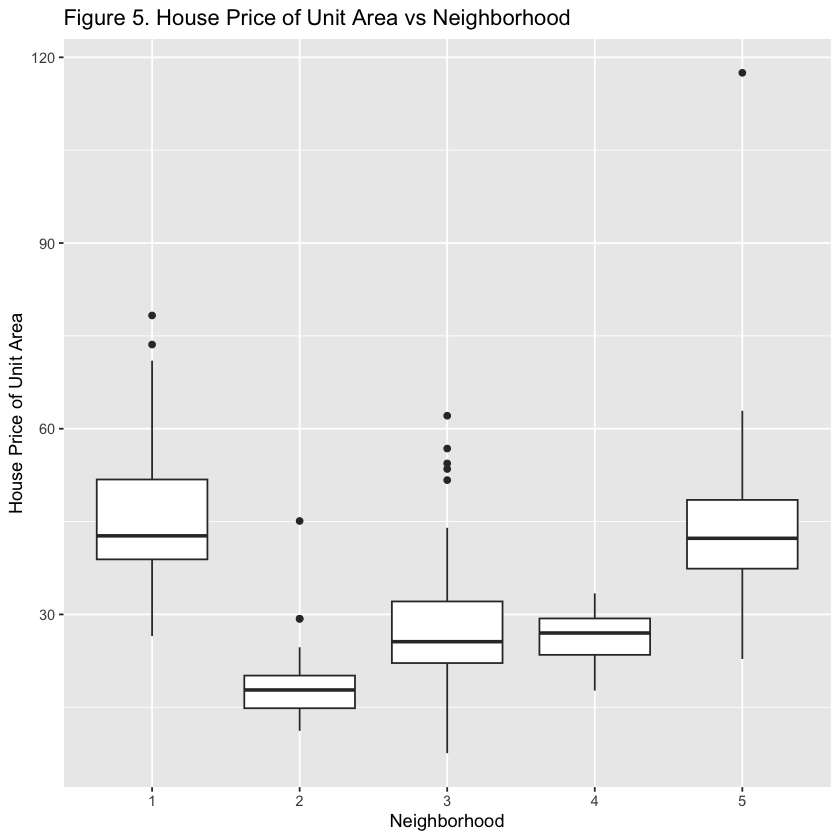

In [29]:
fig_5 <- df_train %>%
    ggplot(aes(x = as.factor(neighborhood), y = y_house_price_of_unit_area)) +
        geom_boxplot() + 
        xlab("Neighborhood") + 
        ylab("House Price of Unit Area") +
        ggtitle("Figure 5. House Price of Unit Area vs Neighborhood")
fig_5
ggsave("figures/fig_5.png", fig_5, width = 20, height = 10, units = "cm")

Since we represent locational data as clusters, it is inherently a categorical variable. This boxplot demonstrates that there seems to be some indication that specific neighborhoods/regions have higher priced houses compared to others. This could be a result of major cities/neighbourhoods having a higher cost of living compared to non-major cities/neighbourhoods; for example, in BC, a similar pattern can be seen between Metro Vancouver and the Okanagan.

To further explore our data, we can create a correlation matrix to identify any potentially collinear features. We do not include neighbourhood here it is a categorical feature

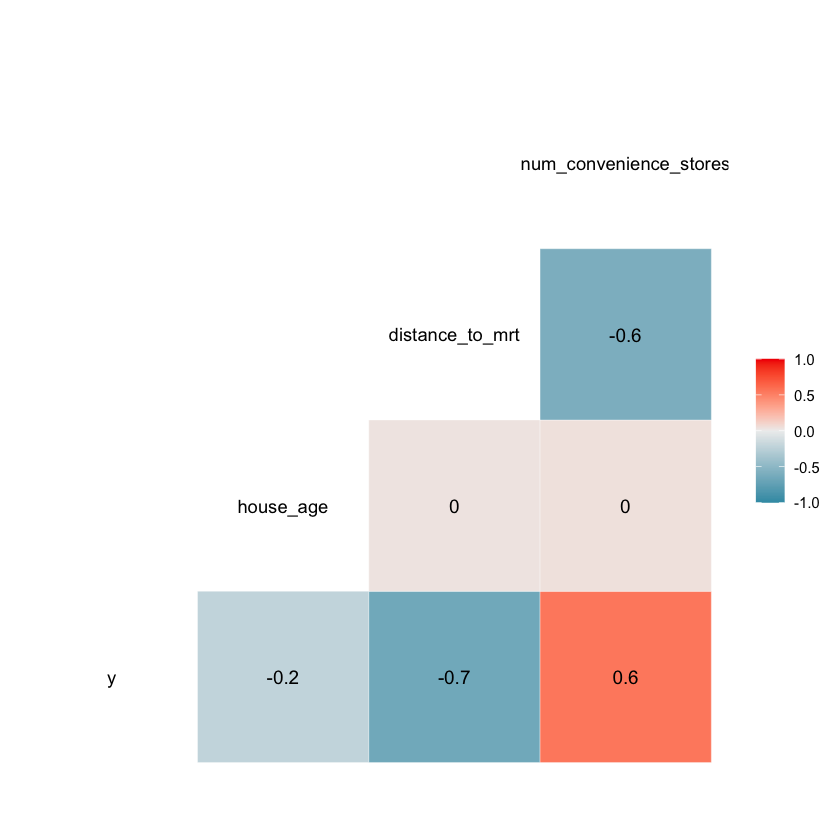

In [30]:
fig_6 <- df_train %>%
    mutate(y = y_house_price_of_unit_area,
        house_age = x2_house_age,
        distance_to_mrt = x3_distance_to_the_nearest_mrt_station,
        num_convenience_stores = x4_number_of_convenience_stores,
        neighborhood = as.factor(neighborhood)
    ) %>%
    select(
        y,
        house_age,
        distance_to_mrt,
        num_convenience_stores
    ) %>%
    ggcorr(label=TRUE)

fig_6
ggsave("figures/fig_6.png", fig_6, width = 20, height = 10, units = "cm")

As observed in the above correlation matrix, there exists a collinear relationship between distance to mtr and the number of convenience stores.

We may now explore the distribution of our response variable $y$ (House price of unit area)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


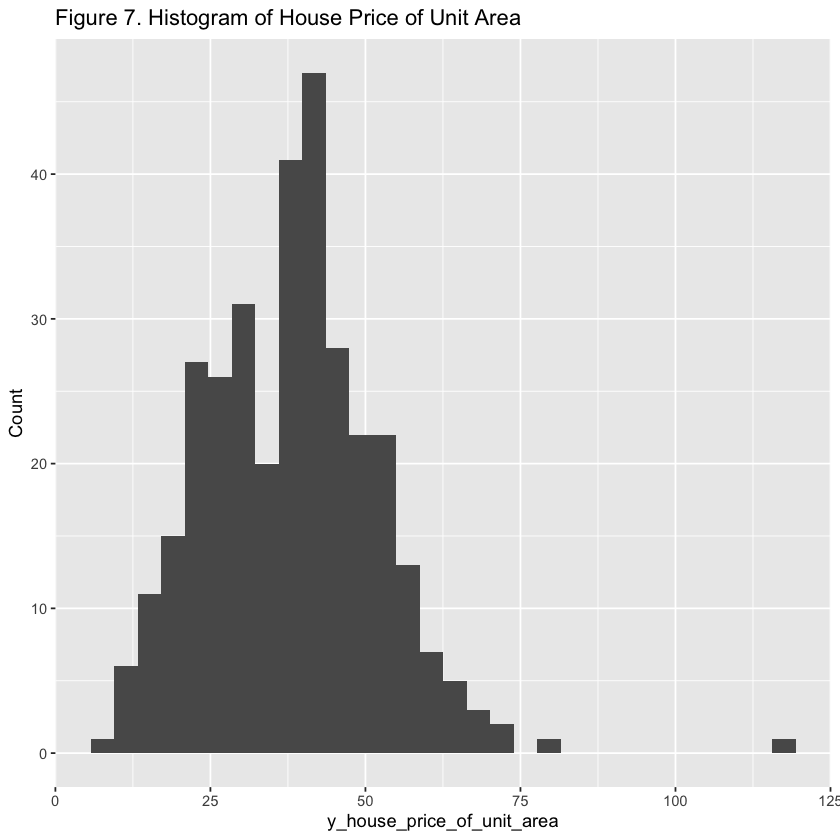

In [31]:
fig_7 <- df_train %>%
    ggplot(aes(x=y_house_price_of_unit_area)) +
        geom_histogram() +
        ylab("House Price of Unit Area") +
        ylab("Count") +
        ggtitle("Figure 7. Histogram of House Price of Unit Area")
        
fig_7
ggsave("figures/fig_7.png", fig_7, width = 20, height = 10, units = "cm")

The data seems to be relatively normally distributed. That being said, there exists an outlier that may be of interest to explore. This outlier has a price that is significantly beyond that of the rest of the data with a house price of unit area at $117.5$.

This observation is quite close compared to the mean distance ($\bar x = 1087.988, x_i = 252.582$)to its nearest mrt station which partially explains its high price. However it is close to only one convenience store (average is 4), this goes against the initial data analysis where a greater number convenience stores suggests a greater expected price. It is important to also note that the grand mean of house prices is $y=38.012$ whereas the mean house price within this house's neighbourhood (5) is 43.418.

In a more advanced attempt at this project, stratification and cluster sampling schemes could be employed to obtain a better understanding of the data

In [32]:
outlier_obs <- df_train[df_train$y_house_price_of_unit_area > 100, c(4,5,9,8)]

outlier_obs
write.csv(outlier_obs, "figures/table2.csv", row.names=TRUE)

x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,neighborhood,y_house_price_of_unit_area
<dbl>,<dbl>,<int>,<dbl>
252.5822,1,5,117.5


In [33]:
mean(df_train$x3_distance_to_the_nearest_mrt_station)
mean(df_train$x4_number_of_convenience_stores)
mean(df_train$y_house_price_of_unit_area)
mean(df_train[df_train$neighborhood == 5,]$y_house_price_of_unit_area)

[1] 1087.988

[1] 4.009119

[1] 38.01216

[1] 43.41782

# Feature Engineering & Model Development

In [34]:
df_train$distance_to_mrt_category <- cut(df_train$x3_distance_to_the_nearest_mrt_station,
                            breaks = c(-Inf, 250, 500, 750, 1000, Inf),
                            labels = c("under_250m", "250m_500m", "500m_750m", "750m_1000m", "over_1000m"))

model_df <- select(df_train, -c(no))

## Model Selection

In [35]:
s <- regsubsets(y_house_price_of_unit_area ~. - x1_transaction_date - x3_distance_to_the_nearest_mrt_station, data = model_df, method = "exhaustive", nvmax = 100)
ss <- summary(s)

rss <- ss$rss
adjr2 <- ss$adjr2
bic <- ss$bic

variables <- data.frame((ss$which))
variables$model <- rownames(variables)
rownames(variables) <- 1:nrow(variables)

rss <- ss$rss
adjr2 <- ss$adjr2
bic <- ss$bic

output <- cbind(variables, RSS=rss, AdjR2=adjr2, BIC=bic)

best_adjr2 <- which.max(output$AdjR2) 
print(best_adjr2)
print(max(output$AdjR2))
output %>% slice(best_adjr2)

output <- output %>%
  mutate(RSS = round(RSS, 3),
         AdjR2 = round(AdjR2, 3),
         BIC = round(BIC, 3)) %>% 
         t()

write.csv(output, "figures/table3.csv", row.names=TRUE)
output

[1] 9
[1] 0.6140666


X.Intercept.,x2_house_age,x4_number_of_convenience_stores,x5_latitude,x6_longitude,neighborhood,distance_to_mrt_category250m_500m,distance_to_mrt_category500m_750m,distance_to_mrt_category750m_1000m,distance_to_mrt_categoryover_1000m,model,RSS,AdjR2,BIC
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,9,23369.06,0.6140666,-264.4307


,1,2,3,4,5,6,7,8,9
X.Intercept.,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
x2_house_age,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
x4_number_of_convenience_stores,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE
x5_latitude,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
x6_longitude,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE
neighborhood,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
distance_to_mrt_category250m_500m,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE
distance_to_mrt_category500m_750m,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE
distance_to_mrt_category750m_1000m,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
distance_to_mrt_categoryover_1000m,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


## Interpretation Of The Results

## Results Validation
### Hypothesis Testing

In [36]:
reg = lm(y_house_price_of_unit_area ~. - x1_transaction_date - x3_distance_to_the_nearest_mrt_station, data = model_df)
model_sum <- summary(reg)
model_sum
p_values<- coef(model_sum)[, "Pr(>|t|)"]
tidy_p_values <- data.frame(P_Value = p_values)

write.csv(tidy_p_values, "figures/table4.csv", row.names=TRUE)
tidy_p_values


Call:
lm(formula = y_house_price_of_unit_area ~ . - x1_transaction_date - 
    x3_distance_to_the_nearest_mrt_station, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.076  -4.054  -0.818   3.187  73.740 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        -1.491e+04  4.819e+03  -3.094  0.00215 ** 
x2_house_age                       -2.846e-01  4.358e-02  -6.531 2.58e-10 ***
x4_number_of_convenience_stores     3.695e-01  2.304e-01   1.604  0.10979    
x5_latitude                         3.208e+02  5.420e+01   5.919 8.35e-09 ***
x6_longitude                        5.716e+01  3.965e+01   1.442  0.15039    
neighborhood                       -4.508e-01  3.576e-01  -1.261  0.20833    
distance_to_mrt_category250m_500m  -3.337e+00  1.388e+00  -2.404  0.01678 *  
distance_to_mrt_category500m_750m  -4.587e+00  2.013e+00  -2.279  0.02331 *  
distance_to_mrt_category750m_1000m -1.101e+01  2.722

,P_Value
,<dbl>
(Intercept),2.152519e-03
x2_house_age,2.579436e-10
x4_number_of_convenience_stores,1.097933e-01
x5_latitude,8.348785e-09
x6_longitude,1.503920e-01
neighborhood,2.083330e-01
distance_to_mrt_category250m_500m,1.677978e-02
distance_to_mrt_category500m_750m,2.330732e-02
distance_to_mrt_category750m_1000m,6.518052e-05


A low p value (p $\leq$ 0.05 by default) suggests the variable is statistically significant. In the best model we selected, variables like `x2_house_age`, `distance_to_mrt_category`, `x5_latitude` and the intercept all have p value below 0.05. It indicates that these variables are statistically significant, while `x4_number_of_convenience_stores`, ` x6_longitude` and `neighborhood` are not. Nevertheless, the the model as a whole is significant because the p value of F statistic is far below 0.05. It indicates these selected predictors have effect on the response variable `y_house_price_of_unit_area` collectively.

We are not supposed to remove the variables that are less significant (p > 0.05) at this stage because this would consist of using the data to find significant variables. We could not fully trust the inference quantities (Std. Error and t-values) in the re-fitted model. All components of variable selection should be done in the `model_df` data set so that we can have an accurate estimate of the uncertainties in price inference.

In [37]:
preprocess_data <- function(data){
    data$distance_to_mrt_category <- cut(data$x3_distance_to_the_nearest_mrt_station,
                            breaks = c(-Inf, 250, 500, 750, 1000, Inf),
                            labels = c("under_250m", "250m_500m", "500m_750m", "750m_1000m", "over_1000m"))

    data$neighborhood <- predict_kmeans(data[, c('x5_latitude', 'x6_longitude')], kmeans_model)

    return(data)
}



processed_df_train <- preprocess_data(train_df)
train_pred_y <- predict(reg, processed_df_train)

processed_df_test <- preprocess_data(test_df)
test_pred_y <- predict(reg, processed_df_test)


error_train <- sqrt(mean((processed_df_train$y_house_price_of_unit_area - predict(reg, processed_df_train))^2))
error_test <- sqrt(mean((processed_df_test$y_house_price_of_unit_area - predict(reg, processed_df_test))^2))

paste0("Training RMSE: ", round(error_train, 3))
paste0("Testing RMSE: ", round(error_test, 3))

[1] "Training RMSE: 8.428"

[1] "Testing RMSE: 6.413"